# EJERCICIO 2 CLASIFICACIÓN
Deberá entrenar un modelo de clasificación para generar las respuestas que hará el servicio.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, r2_score, confusion_matrix, mean_absolute_error

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier, XGBRegressor


from config.config_file import PATH_ALFA_BETHA_FILE



In [2]:
#leer el dataset
data = pd.read_csv(PATH_ALFA_BETHA_FILE, sep=',', index_col=0)
data

,SeniorCity,Partner,Dependents,Service1,Service2,Security,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,Charges,Demand,Class
autoID,,,,,,,,,,,,,,,
7590-VHVEG,0,Yes,No,No,No phone service,No,Yes,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,Alpha
5575-GNVDE,0,No,No,Yes,No,Yes,No,Yes,No,One year,No,Mailed check,56.95,1889.5,Alpha
3668-QPYBK,0,No,No,Yes,No,Yes,Yes,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Betha
7795-CFOCW,0,No,No,No,No phone service,Yes,No,Yes,Yes,One year,No,Bank transfer (automatic),42.30,1840.75,Alpha
9237-HQITU,0,No,No,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Betha
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,0,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,Alpha
2234-XADUH,0,Yes,Yes,Yes,Yes,No,Yes,Yes,No,One year,Yes,Credit card (automatic),103.20,7362.9,Alpha
4801-JZAZL,0,Yes,Yes,No,No phone service,Yes,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,Alpha


## DESCRIPCIÓN DEL DATASET

In [3]:
unique_values = {col : data[col].unique() for col in data.columns}
for col, values in unique_values.items():
    print(f'columna:  {col}')
    print(f'Número devalores únicos: {len(values)}')
    print(f'Valores únicos: {values[:10]}')
    print('-' *50)

columna:  SeniorCity
Número devalores únicos: 2
Valores únicos: [0 1]
--------------------------------------------------
columna:  Partner
Número devalores únicos: 2
Valores únicos: ['Yes' 'No']
--------------------------------------------------
columna:  Dependents
Número devalores únicos: 2
Valores únicos: ['No' 'Yes']
--------------------------------------------------
columna:  Service1
Número devalores únicos: 2
Valores únicos: ['No' 'Yes']
--------------------------------------------------
columna:  Service2
Número devalores únicos: 3
Valores únicos: ['No phone service' 'No' 'Yes']
--------------------------------------------------
columna:  Security
Número devalores únicos: 3
Valores únicos: ['No' 'Yes' 'No internet service']
--------------------------------------------------
columna:  OnlineBackup
Número devalores únicos: 3
Valores únicos: ['Yes' 'No' 'No internet service']
--------------------------------------------------
columna:  DeviceProtection
Número devalores únicos: 3
V

# Los datos contenidos en la tabla presentan:
7043 rows × 15 columns
| **Campo**          | **Descripción**                                      | **Tipo de dato**  |
|--------------------|------------------------------------------------------|-------------------|
| autoID            | Identificador único                                  | `int`            |
| SeniorCity        | Valores booleanos (0 y 1)                            | `boolean`        |
| Partner          | Indica si tiene pareja (yes/no)                       | `object`         |
| Dependents        | Indica si tiene dependientes (yes/no)                 | `object`         |
| Service1         | Servicio activado (yes/no)                             | `object`         |
| Service2         | Servicio activado (yes/no/'No phone service')          | `object`         |
| Security         | Seguridad activada (yes/no/'No internet service')      | `object`         |
| OnlineBackup     | Estado del respaldo en línea ('Yes'/'No'/'No internet service') | `object`         |
| DeviceProtection | Protección del dispositivo ('Yes'/'No'/'No internet service') | `object`         |
| TechSupport      | Soporte técnico disponible ('Yes'/'No'/'No internet service') | `object`         |
| Contract        | Tipo de contrato ('Month-to-month'/'One year'/'Two year') | `object`         |
| PaperlessBilling | Facturación sin papel ('Yes'/'No')                     | `object`         |
| PaymentMethod   | Método de pago ('Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)') | `object`         |
| Charges        | Costos asociados                                       | `float`            |
| Demand        | Nivel de demanda estimado                                | `object`            |
| Class          | Clasificación ('Alpha'/'Betha')                         | `object`         |


In [4]:
#infot de los datos
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SeniorCity        7043 non-null   int64  
 1   Partner           7043 non-null   object 
 2   Dependents        7043 non-null   object 
 3   Service1          7043 non-null   object 
 4   Service2          7043 non-null   object 
 5   Security          7043 non-null   object 
 6   OnlineBackup      7043 non-null   object 
 7   DeviceProtection  7043 non-null   object 
 8   TechSupport       7043 non-null   object 
 9   Contract          7043 non-null   object 
 10  PaperlessBilling  7043 non-null   object 
 11  PaymentMethod     7043 non-null   object 
 12  Charges           7043 non-null   float64
 13  Demand            7043 non-null   object 
 14  Class             7043 non-null   object 
dtypes: float64(1), int64(1), object(13)
memory usage: 880.4+ KB


Demand está como un object toca se debe cambiar por un float

In [5]:
# Cambiar Demand que es tipo object a float, manejando valores en blanco
data['Demand'] = data['Demand'].replace(' ', 0).astype(float)
data['Demand'].dtype

dtype('float64')

In [6]:
#datdos nulos 
print("Datos nulos por columna:")
print(data.isnull().sum())

Datos nulos por columna:
SeniorCity          0
Partner             0
Dependents          0
Service1            0
Service2            0
Security            0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
Contract            0
PaperlessBilling    0
PaymentMethod       0
Charges             0
Demand              0
Class               0
dtype: int64


# Los datos contenidos en la tabla actualizados:
7043 rows × 15 columns
| **Campo**          | **Descripción**                                      | **Tipo de dato**  |
|--------------------|------------------------------------------------------|-------------------|
| autoID            | Identificador único                                  | `int`            |
| SeniorCity        | Valores booleanos (0 y 1)                            | `boolean`        |
| Partner          | Indica si tiene pareja (yes/no)                       | `object`         |
| Dependents        | Indica si tiene dependientes (yes/no)                 | `object`         |
| Service1         | Servicio activado (yes/no)                             | `object`         |
| Service2         | Servicio activado (yes/no/'No phone service')          | `object`         |
| Security         | Seguridad activada (yes/no/'No internet service')      | `object`         |
| OnlineBackup     | Estado del respaldo en línea ('Yes'/'No'/'No internet service') | `object`         |
| DeviceProtection | Protección del dispositivo ('Yes'/'No'/'No internet service') | `object`         |
| TechSupport      | Soporte técnico disponible ('Yes'/'No'/'No internet service') | `object`         |
| Contract        | Tipo de contrato ('Month-to-month'/'One year'/'Two year') | `object`         |
| PaperlessBilling | Facturación sin papel ('Yes'/'No')                     | `object`         |
| PaymentMethod   | Método de pago ('Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)') | `object`         |
| Charges        | Costos asociados                                       | `float`            |
| Demand        | Nivel de demanda estimado                                | `float`            |
| Class          | Clasificación ('Alpha'/'Betha')                         | `object`         |


# variables categoricas 
Para entender mejor los datos y las variables, es necesario codificar las variables (one-hot encoding o label encoding), con el fin de detectar que categorías pueden afectar la precisión del modelo.

- Partner,
Dependents,
Service1,
Service2,
Security,
OnlineBackup,
DeviceProtection,
TechSupport,
Contract,
PaperlessBilling,
PaymentMethod,
Class, PRESENTAN VALORES ENTRE YES, NO Y OTRO POR LO QUE LAS CONVIERTE EN VARIABLES CATEGORÍCAS

In [ ]:
# Seleccionar las variables categóricas

cat_vars = data.select_dtypes(include=['object']).columns
print("Categorical variables:", cat_vars)
for var in cat_vars:
    print(f"\n{var}'s distribution:")
    print(data[var].value_counts(normalize=True))

Categorical variables: Index(['Partner', 'Dependents', 'Service1', 'Service2', 'Security',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'Class'],
      dtype='object')

Partner's distribution:
Partner
No     0.516967
Yes    0.483033
Name: proportion, dtype: float64

Dependents's distribution:
Dependents
No     0.700412
Yes    0.299588
Name: proportion, dtype: float64

Service1's distribution:
Service1
Yes    0.903166
No     0.096834
Name: proportion, dtype: float64

Service2's distribution:
Service2
No                  0.481329
Yes                 0.421837
No phone service    0.096834
Name: proportion, dtype: float64

Security's distribution:
Security
No                     0.496663
Yes                    0.286668
No internet service    0.216669
Name: proportion, dtype: float64

OnlineBackup's distribution:
OnlineBackup
No                     0.438450
Yes                    0.344881
No internet service    0.216669
Nam

# Varibles numéricas

In [25]:
num_vars = data.select_dtypes(include=['int64', 'float64']).columns
print("Numerical variables:", num_vars)

Numerical variables: Index(['SeniorCity', 'Charges', 'Demand'], dtype='object')


# VISUALIZACIÓN DE LA DISTRIBUCIÓN DE DATOS

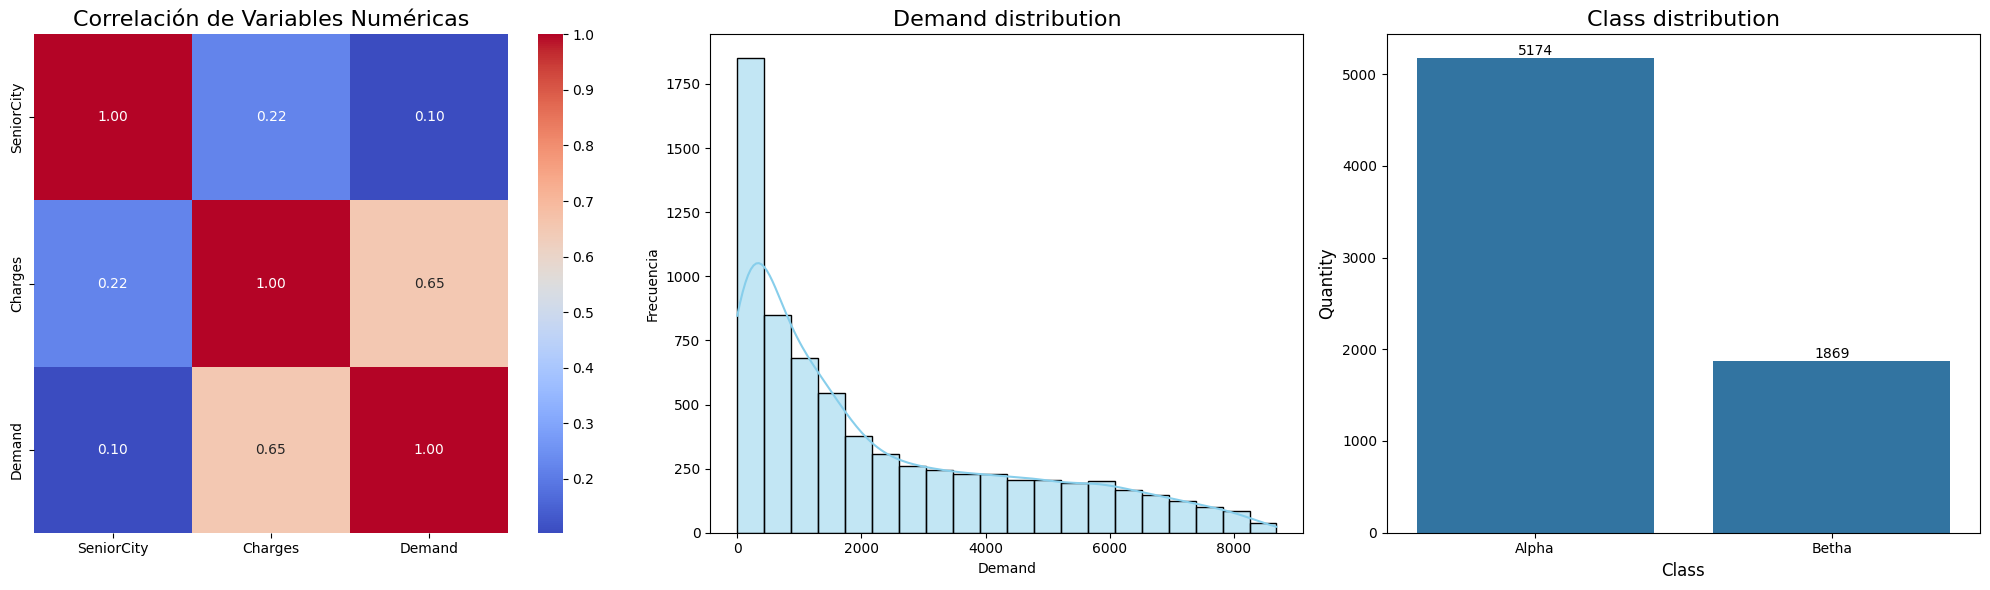

In [33]:
# Crear figura con 3 subgráficos
fig, axes = plt.subplots(1, 3, figsize=(20, 6))  # 1 fila, 3 columnas

# --- 1. Heatmap (Mapa de calor de correlación)
sns.heatmap(data[num_vars].corr(), annot=True, fmt='.2f', cmap='coolwarm', ax=axes[0])
axes[0].set_title('Correlación de Variables Numéricas', fontsize=16)

# --- 2. Histograma (por ejemplo, de "demand")
sns.histplot(data['Demand'], bins=20, kde=True, ax=axes[1], color='skyblue')
axes[1].set_title('Demand distribution', fontsize=16)
axes[1].set_xlabel('Demand')
axes[1].set_ylabel('Frecuencia')

# --- 3. Gráfico de barras (distribución de clases)
ax = sns.barplot(x=data['Class'].value_counts().index, 
                y=data['Class'].value_counts().values)

for i, v in enumerate(data['Class'].value_counts().values):
    ax.text(i, v, str(v), ha='center', va='bottom')

plt.title('Class distribution', fontsize=16)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Quantity', fontsize=12)

plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

